# CutMix 또는 Mixup 비교실험 하기

CutMix 또는 Mixup 기법을 적용해 ResNet-50모델을 훈련시켜 보도록 하겠습니다.  
데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시킵니다. 그리고 결과를 수치화하고 비교합니다.

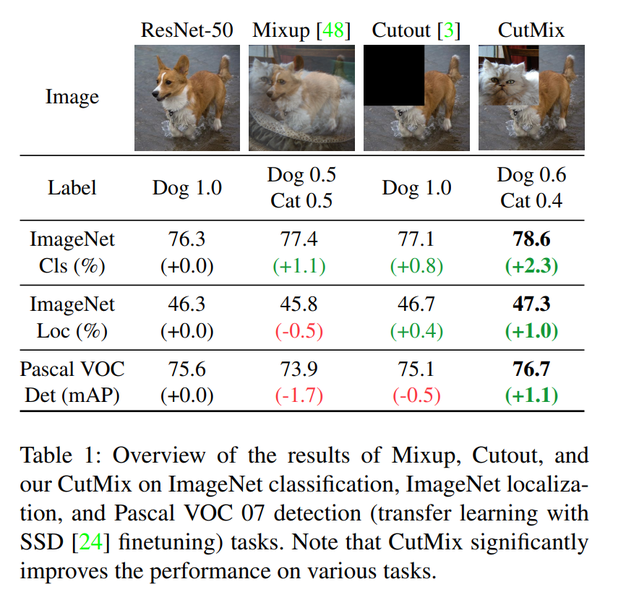

- **Mixup : 이미지의 픽셀값을 특정 비율로 섞는 방식**
- **CutMix : 이미지의 일정 영역을 잘라서 붙여주는 방식**  
    *CutMix는 이미지뿐만 아니라 라벨도 섞어야 합니다.*

## 1. 데이터 불러오기

**stanford_dogs 데이터셋**  
- 120개 견종의 이미지
- 총 데이터 : 20,580장
- 학습 데이터 : 12,000장
- 테스트 데이터 : 8,580장

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

tf.random.set_seed(2020)

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    # shuffle_files=True,
    with_info=True,
)

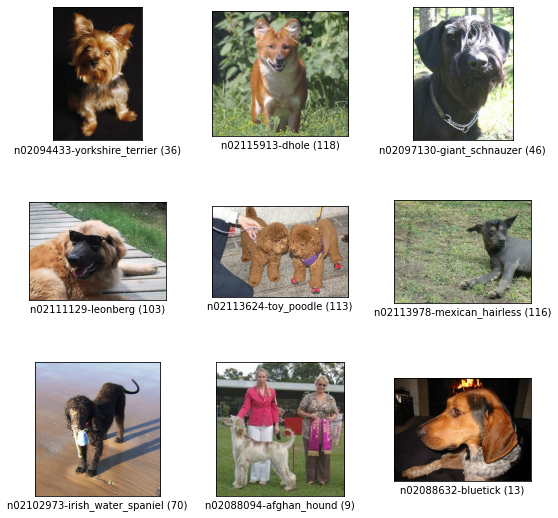

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

## 2. Augmenetaion 적용하기

### 1) 전처리 함수 만들기

Augmentaion을 적용하기에 앞서 이미지를 변환하는 기본적인 전처리 함수를 만들도록 하겠습니다.

**`normalize_and_resize_img(image, label)`**  
> image의 크기를 224x224로 변경하고 픽셀값을 0~1사이의 정수로 변환시킵니다.

In [5]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

위의 함수는 입력받은 이미지를 0~1 사이의 float32로 normalize하고, 224x224 사이즈를 resize합니다.  
이 함수는 train 과 test 로 사용될 모든 이미지에 적용할 것입니다.

### 2) augmentation 함수 만들기

**`augment(image, label)`**  
> 랜덤하게 image를 좌우 반전시키고, 밝기 조절을 합니다.

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)    # 이미지 좌우 반전
    image = tf.image.random_brightness(image, max_delta=0.2)    # 이미지 밝기 조절
    return image,label

### 3) CutMix 함수 만들기

**`get_clip_box(image_a, image_b)`** (이미지 섞기 - 1)  
> 랜덤하게 image의 바운딩 박스 좌표를 뽑습니다. (top-left, bottom-right)

In [7]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)
    
    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

# xa, ya, xb, yb = get_clip_box(image_a, image_b)
# print("top-left (x,y) :", xa.numpy(), ya.numpy())
# print("bottom-right (x,y) :", xb.numpy(), yb.numpy())

**`mix_2_images(image_a, image_b, xa, ya, xb, yb)`** (이미지 섞기 - 2)  
> 바운딕 박스 좌표를 이용하여, 바탕 이미지 a에서 바운딩 박스 바깥쪽 영역을,  이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합칩니다.

In [8]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
# plt.imshow(mixed_img.numpy())

**`mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes)`** (라벨 섞기)  
> mix된 이미지의 비율에 맞추어 라벨을 구합니다.

In [9]:
# mix two labels
def mix_2_label(image_a, label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b

    return mixed_label

# print("label_a :", label_a.numpy())
# print("label_b :", label_b.numpy())
# mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
# mixed_label

**`cutmix(image, label, prob, batch_size, img_size, num_classes)`** (cutmix 하기)  
> 배치 단위로 image를 cutmix하고, cutmix한 이미지의 라벨을 구합니다.

In [10]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(image_a, label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 4) Mixup 함수 만들기

**`mixup_2_images(image_a, image_b, label_a, label_b)`**  
> image를 mixup 하고, mixup 한 image의 라벨을 구합니다.

In [11]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
        
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

# mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
# print("label_a :", label_a.numpy())
# print("label_b :", label_b.numpy())
# print(mixed_label)
# plt.imshow(mixed_img.numpy())

**`mixup(image, label, prob, batch_size, img_size, num_classes)`**  
> 배치단위로 image를 mixup 하고, mixup 한 image의 라벨을 구합니다.

In [12]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 5) 전처리, Augmentation, CutMix, Mixup 을 데이터셋에 적용할 함수 만들기

위에서 구현한 함수들을 데이터셋에 적용할 수 있는 함수를 만들도록 하겠습니다.

**`apply_normalize_on_dataset(ds, is_test, batch_size, with_aug, with_cutmix)`**  
> image 전처리 (normalize, resize, augmentation, shuffle, cutmix) 하기  

*!! 주의 !! shuffle 이나 augmentation은 테스트 데이터셋에는 적용하면 안됩니다.*

In [13]:
# 테스트 데이터 라벨을 원핫 인코딩하는 함수
def onehot(test_img, test_label):
    test_label = tf.one_hot(test_label, 120)
    return test_img, test_label

In [14]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    # 이미지 전처리하기
    ds = ds.map(
        normalize_and_resize_img,    # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    
    # 학습 데이터에 augmentation 적용을 한다면 수행 
    if not is_test and with_aug:
        ds = ds.map(
            augment,    # augment 함수 적용 (좌우 반전, 밝기조절)
        )
        
    ds = ds.batch(batch_size)
    
    # 학습 데이터에 
    if not is_test:
        # cutmix 적용을 한다면 수행
        if with_cutmix:
            ds = ds.map(
                cutmix,    # cutmix 함수 적용
                num_parallel_calls=2
            )
        # mixup 함수 적용 
        if with_mixup:
            ds = ds.map(
                mixup,    # mixup 함수 적용
                num_parallel_calls=2
            )
    # 테스트 데이터라면
    if is_test:
        ds = ds.map(
            onehot,    # onehot 함수 적용
            num_parallel_calls=2    
        )
        
    # 학습 데이터 repeat 데이터로 생성하고 섞기
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

## 3. 모델 만들기

In [15]:
num_classes = ds_info.features["label"].num_classes

### 1) No Augmentation

In [16]:
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [17]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train)

### 2) Augmentation

In [18]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [19]:
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

### 3) Augmentation + CutMix

In [20]:
aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [21]:
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)

### 4) Augmentation + Mixup

In [22]:
aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [23]:
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

test 데이터 변경하기

In [24]:
ds_test_one_hot = apply_normalize_on_dataset(ds_test, is_test=True)

In [25]:
ds_test = ds_test.map(normalize_and_resize_img)
ds_test = ds_test.batch(16)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## 4. 모델 훈련하기

In [26]:
EPOCH = 20

### 1) No Augmentation

In [27]:
no_aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [28]:
history_no_aug_resnet50 = no_aug_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Train for 750 steps, validate for 536 steps
Epoch 1/20
750/750 [==============================] - 130s 174ms/step - loss: 2.2047 - accuracy: 0.4501 - val_loss: 3.1260 - val_accuracy: 0.2554
Epoch 2/20
750/750 [==============================] - 124s 166ms/step - loss: 0.6833 - accuracy: 0.8155 - val_loss: 1.0735 - val_accuracy: 0.6875
Epoch 3/20
750/750 [==============================] - 125s 166ms/step - loss: 0.1800 - accuracy: 0.9666 - val_loss: 0.9372 - val_accuracy: 0.7271
Epoch 4/20
750/750 [==============================] - 125s 166ms/step - loss: 0.0470 - accuracy: 0.9977 - val_loss: 0.8979 - val_accuracy: 0.7396
Epoch 5/20
750/750 [==============================] - 125s 167ms/step - loss: 0.0204 - accuracy: 0.9996 - val_loss: 0.9114 - val_accuracy: 0.7400
Epoch 6/20
750/750 [==============================] - 125s 167ms/step - loss: 0.0127 - accuracy: 0.9999 - val_loss: 0.9236 - val_accuracy: 0.7417
Epoch 7/20
750/750 [==============================] - 125s 167ms/step - loss: 0.

In [29]:
np.save('history_no_aug_resnet50.npy',history_no_aug_resnet50.history)

In [30]:
# history_no_aug_resnet50 = np.load('history_no_aug_resnet50.npy',allow_pickle='TRUE').item()

### 2) Augmentation

In [31]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [32]:
history_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Train for 750 steps, validate for 536 steps
Epoch 1/20
750/750 [==============================] - 130s 173ms/step - loss: 2.2340 - accuracy: 0.4403 - val_loss: 2.8649 - val_accuracy: 0.2878
Epoch 2/20
750/750 [==============================] - 125s 167ms/step - loss: 0.8740 - accuracy: 0.7487 - val_loss: 1.1140 - val_accuracy: 0.6673
Epoch 3/20
750/750 [==============================] - 125s 167ms/step - loss: 0.4261 - accuracy: 0.8873 - val_loss: 1.0878 - val_accuracy: 0.6853
Epoch 4/20
750/750 [==============================] - 125s 167ms/step - loss: 0.2109 - accuracy: 0.9531 - val_loss: 0.9635 - val_accuracy: 0.7218
Epoch 5/20
750/750 [==============================] - 125s 167ms/step - loss: 0.1091 - accuracy: 0.9811 - val_loss: 0.9657 - val_accuracy: 0.7274
Epoch 6/20
750/750 [==============================] - 125s 167ms/step - loss: 0.0588 - accuracy: 0.9925 - val_loss: 0.9450 - val_accuracy: 0.7378
Epoch 7/20
750/750 [==============================] - 125s 167ms/step - loss: 0.

In [33]:
np.save('history_aug_resnet50.npy',history_aug_resnet50.history)

In [5]:
history_aug_resnet50 = np.load('history_aug_resnet50.npy',allow_pickle='TRUE').item()

[2.23396617992719,
 0.8739567935665449,
 0.42608016736308735,
 0.21089000392953555,
 0.10908965224027634,
 0.058822723985960085,
 0.030918595052013796,
 0.020522166094121833,
 0.014220165658121307,
 0.009994418268402418,
 0.007903133714571596,
 0.006334816350912055,
 0.005630826761014759,
 0.00468057541269809,
 0.004141928969261547,
 0.003711846521589905,
 0.003360703454663356,
 0.0031318041887134314,
 0.002887729681873073,
 0.002673899993610879]

### 3) Augmentation + CutMix

In [35]:
aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [36]:
history_aug_cutmix_resnet50 = aug_cutmix_resnet50.fit(
    ds_train_aug_cutmix, # augmentation + cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_one_hot,
    verbose=1,
    use_multiprocessing=True,
)

Train for 750 steps, validate for 536 steps
Epoch 1/20
750/750 [==============================] - 133s 177ms/step - loss: 3.8355 - accuracy: 0.2124 - val_loss: 3.1897 - val_accuracy: 0.2225
Epoch 2/20
750/750 [==============================] - 127s 169ms/step - loss: 2.9909 - accuracy: 0.4177 - val_loss: 1.3813 - val_accuracy: 0.6193
Epoch 3/20
750/750 [==============================] - 127s 170ms/step - loss: 2.6931 - accuracy: 0.5132 - val_loss: 1.3064 - val_accuracy: 0.6307
Epoch 4/20
750/750 [==============================] - 130s 173ms/step - loss: 2.5342 - accuracy: 0.5583 - val_loss: 1.3827 - val_accuracy: 0.6226
Epoch 5/20
750/750 [==============================] - 128s 171ms/step - loss: 2.4149 - accuracy: 0.5941 - val_loss: 1.2465 - val_accuracy: 0.6616
Epoch 6/20
750/750 [==============================] - 128s 171ms/step - loss: 2.2689 - accuracy: 0.6449 - val_loss: 1.1298 - val_accuracy: 0.6840
Epoch 7/20
750/750 [==============================] - 130s 173ms/step - loss: 2.

In [37]:
np.save('history_aug_cutmix_resnet50.npy',history_aug_cutmix_resnet50.history)

In [38]:
# history_aug_cutmix_resnet50 = np.load('history_aug_cutmix_resnet50.npy',allow_pickle='TRUE').item()

### 4) Augmentation + Mixup

In [39]:
aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [40]:
history_aug_mixup_resnet50 = aug_mixup_resnet50.fit(
    ds_train_aug_mixup, # augmentation + mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_one_hot,
    verbose=1,
    use_multiprocessing=True,
)

Train for 750 steps, validate for 536 steps
Epoch 1/20
750/750 [==============================] - 133s 177ms/step - loss: 3.7352 - accuracy: 0.2419 - val_loss: 3.7593 - val_accuracy: 0.1405
Epoch 2/20
750/750 [==============================] - 127s 169ms/step - loss: 2.8839 - accuracy: 0.4678 - val_loss: 1.8462 - val_accuracy: 0.5068
Epoch 3/20
750/750 [==============================] - 127s 169ms/step - loss: 2.5260 - accuracy: 0.6032 - val_loss: 1.4545 - val_accuracy: 0.6069
Epoch 4/20
750/750 [==============================] - 127s 170ms/step - loss: 2.4889 - accuracy: 0.6133 - val_loss: 1.3196 - val_accuracy: 0.6327
Epoch 5/20
750/750 [==============================] - 127s 169ms/step - loss: 2.3700 - accuracy: 0.6658 - val_loss: 1.2229 - val_accuracy: 0.6575
Epoch 6/20
750/750 [==============================] - 127s 169ms/step - loss: 2.2624 - accuracy: 0.6970 - val_loss: 1.2986 - val_accuracy: 0.6440
Epoch 7/20
750/750 [==============================] - 127s 169ms/step - loss: 2.

In [41]:
np.save('history_aug_mixup_resnet50.npy',history_aug_mixup_resnet50.history)

In [42]:
# history_aug_mixup_resnet50 = np.load('history_aug_mixup_resnet50.npy',allow_pickle='TRUE').item()

## 5. 훈련 과정 시각화하기

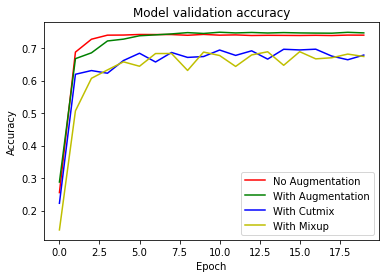

In [45]:
plt.plot(history_no_aug_resnet50.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50.history['val_accuracy'], 'g')
plt.plot(history_aug_cutmix_resnet50.history['val_accuracy'], 'b')
plt.plot(history_aug_mixup_resnet50.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='lower right')
plt.show()

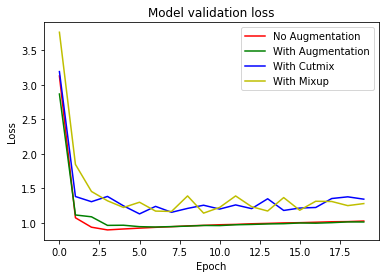

In [47]:
plt.plot(history_no_aug_resnet50.history['val_loss'], 'r')
plt.plot(history_aug_resnet50.history['val_loss'], 'g')
plt.plot(history_aug_cutmix_resnet50.history['val_loss'], 'b')
plt.plot(history_aug_mixup_resnet50.history['val_loss'], 'y')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper right')
plt.show()

## 6. Augmentation 에 의한 모델 성능 비교

|  | No Augmentation | With Augmentation | With Cutmix | With Mixup |
|:----------|:----------:|:----------:|:----------:|:----------:|
| Accuracy 성능 순위 | 2 | 1 | 3 | 3 |
| Loss 성능 순위 | 1 | 1 | 2 | 2 |

결과를 보면 이미지 전처리 하지 않은 모델이 다른 모델들에 비해 성능이 좋게 나왔습니다.  
왜 그런지 원인은 파악하지 못했습니다.

## 7. 루브릭

**1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?**

Cutmix 와 Mixup 를 적용한 데이터 셋으로 각각 ResNet 모델을 학습시켰을때, loss가 줄어들고 accuracy가 증가하였습니다.

**2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?**

Augmentation 적용을 한 모델보다 적용하지 않은 모델의 성능차이는 거의 없었습니다.  
결론적으로 최적의 Augmentation 기법은 찾지 못했습니다.

**3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?**

기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화하여 그래프로 나타냈습니다.